In [5]:
from prettytable import PrettyTable
from math import log, fabs, exp, pi
from copy import *
from tkinter import *
from scipy.interpolate import interp1d
from scipy import arange, array, exp
from matplotlib import pyplot as plot

In [6]:
# -- Input data --
input_Rk = 0.2     # Resistance
input_Lk = 60e-6   # Inductance
input_Ck = 150e-6  # Capacitance capacity
input_Uc = 3000    # The capacitor voltage at the initial time
input_I0 = 0.5     # The current strength of the circuit at the initial time
input_R = 0.35     # Radius of the tube (upper bound of the integral)
input_P0 = 0.5     # This is used in the equation to find the pressure
input_T0 = 300     # This is used in the equation to find the pressure
input_TW = 2000    # This is not particularly affected by the result
input_le = 10      # Distance between lamp electrodes

input_tstart = 1e-5
input_nodes = 200

In [7]:
class SourceTable:
    def __init__(self, first_file, second_file, third_file):
        self.array_n = []   # The concentration of heavy particles n
        self.array_T = []   # Initial data
        self.array_s = []   # Coefficient of electrical conductivity σ
        
        self.array_n_log = []  
        self.array_s_log = []
        
        with first_file, second_file, third_file:
            for line in first_file:
                I, T_0, m = line.split()
                I = float(I)
                T_0 = float(T_0)
                m = float(m)
                self.array_T.insert(len(self.array_T), [I, T_0, m])
            for line in second_file:
                T, first_pressures_n, second_pressures_n, third_pressures_n = line.split()
                T = float(T)
                first_pressures_n = float(first_pressures_n)
                second_pressures_n = float(second_pressures_n)
                third_pressures_n = float(third_pressures_n)
                self.array_n.insert(len(self.array_n), [T, first_pressures_n, second_pressures_n, third_pressures_n])
            for line in third_file:
                T, first_pressures_s, second_pressures_s, third_pressures_s = line.split()
                T = float(T)
                first_pressures_s = float(first_pressures_s)
                second_pressures_s = float(second_pressures_s)
                third_pressures_s = float(third_pressures_s)
                self.array_s.insert(len(self.array_s), [T, first_pressures_s, second_pressures_s, third_pressures_s])
                
        for i in range(0, len(self.array_n)):
            self.array_n_log.append([])
            self.array_s_log.append([])
            for j in range(0, len(self.array_n[0])):
                self.array_n_log[i].append(log(self.array_n[i][j]))
            for j in range(0, len(self.array_s[0])):
                self.array_s_log[i].append(log(self.array_s[i][j]))

    def __repr__(self):
        return str(self.array_n) + '\n' + str(self.array_T)+ '\n' + str(self.array_s)

In [8]:
class Solution:
    def __init__(self):
        self.I = []
        self.U = []
        self.Uc = []
        self.R = []
        self.t = []
    def __repr__(self):
        return ('Solution: \nI:' + str(self.I) + '\nU:' + str(self.U) +
                '\nUc:' + str(self.Uc) + '\nR:' + str(self.R) + '\nt:' + str(self.t))

In [9]:
### Interpolation of tabular data. ###

''' Interpolation in two variables: 
                linear interpolation by pressure and logarithmic by temperature.
    We interpolate not the value of a function, but its logarithm.'''

def get_sigma_or_n(temperature, array_heavy_part, array_heavy_part_log, pressures):
    ''' Obtaining the coefficient of electrical conductivity
        or the concentration of heavy particles. '''
    
    index_temperature = 0  # index of temperature
    index_pressures = 2  # index of pressures

    if temperature <= array_heavy_part[0][0]:
        index_temperature = 1
    elif temperature > array_heavy_part[-1][0]:
        index_temperature = len(array_heavy_part) - 1
    else:
        while array_heavy_part[index_temperature][0] < temperature:
            index_temperature += 1
            
    # Find pressure borders:
    pressures_first = 5
    pressures_second = 15
    if pressures > 15:
        index_pressures = 3
        pressures_first += 10
        pressures_second += 10
        
    # Interpolation:  
    first_concentr_heavy_part = array_heavy_part_log[index_temperature - 1][index_pressures - 1] + (array_heavy_part_log[index_temperature][index_pressures - 1] - array_heavy_part_log[index_temperature - 1][index_pressures - 1]) * (temperature - array_heavy_part[index_temperature - 1][0]) / (array_heavy_part[index_temperature][0] - array_heavy_part[index_temperature - 1][0])
                
    second_concentr_heavy_part = array_heavy_part_log[index_temperature - 1][index_pressures] + (array_heavy_part_log[index_temperature][index_pressures] - array_heavy_part_log[index_temperature - 1][index_pressures]) * (temperature - array_heavy_part[index_temperature - 1][0]) / (array_heavy_part[index_temperature][0] - array_heavy_part[index_temperature - 1][0])
    
    first_concentr_heavy_part = exp(first_concentr_heavy_part)
    second_concentr_heavy_part = exp(second_concentr_heavy_part)
    
    return first_concentr_heavy_part + (second_concentr_heavy_part - first_concentr_heavy_part) * (pressures - pressures_first) / (pressures_second - pressures_first)

In [10]:
def integrate_n(array_temperature, array_heavy_part, array_heavy_part_log, pressures):
    ''' This equation of the form f(x) = 0 can be solved by the dichotomy method.
        Computing the integral by the Simpson method. '''
    r = 0
    h = input_R / (len(array_temperature) - 1)
    total_sum = 0
    for i in range(1, len(array_temperature) - 1):
        r += h
        t = array_temperature[i]
        n = get_sigma_or_n(t, array_heavy_part, array_heavy_part_log, pressures)
        if i % 2 == 0:
            total_sum += 2 * n * r
        else:
            total_sum += 4 * n * r
            
    n = get_sigma_or_n(array_temperature[-1], array_heavy_part, array_heavy_part_log, pressures)
    
    total_sum += n * input_R
    total_sum *= h / 3 * 2 / pow(input_R, 2)
    
    return total_sum - (input_P0 * 7242 / input_T0)

In [11]:
def get_parameters(datatable, I):
    ''' Finding R and everything in our way '''
    abs_I = fabs(I)  # Negative values of I are unwanted
    count = 41       # any even value will go

    # Find T by the means of linear interpolation:
    i = 0
    # Make sure we may extrapolate at one point:
    if abs_I <= datatable.array_T[0][0]:
        i = 1
    elif abs_I > datatable.array_T[-1][0]:
        i = len(datatable.array_T) - 1
    else:
        while datatable.array_T[i][0] < abs_I:
            i += 1
            
    previous = datatable.array_T[i - 1]
    this = datatable.array_T[i]
    t = previous[1] + (this[1] - previous[1]) * (abs_I - previous[0]) / (this[0] - previous[0])
    m = previous[2] + (this[2] - previous[2]) * (abs_I - previous[0]) / (this[0] - previous[0])

    # Find T(r)
    radius = 0
    h = input_R / (count - 1)
    temps = [0] * count
    for i in range (0, count):
        temps[i] = (input_TW - t) * pow(radius / input_R, m) + t
        radius += h

    # Get pressure P and resistance:
    l = 1
    h = 1
    # Get integrals of n by variable rad by the means of Simpson method:
    n_current = 1
    n_next = 1
    while n_current * n_next > 0:
        n_current = integrate_n(temps, datatable.array_n, datatable.array_n_log, l)
        n_next = integrate_n(temps, datatable.array_n, datatable.array_n_log, l + h)
        l += h
    r = l + h
    p = (l + r) / 2

    while (fabs(r - l) / p > 1e-4):
        n_current = integrate_n(temps, datatable.array_n, datatable.array_n_log, l)
        n_next = integrate_n(temps, datatable.array_n, datatable.array_n_log, p)
        if (n_current * n_next < 0):
            r = p
        else:
            l = p
        p = (l + r) / 2

    # Find resistance:
    r = 0
    h = input_R / (len(temps) - 1)
    total_sum = 0
    sigma = 0
    for i in range(1, len(temps) - 2):
        r += h
        sigma = get_sigma_or_n(temps[i], datatable.array_s, datatable.array_s_log, p)
        if i % 2==0:
            total_sum += 2 * sigma * r
        else:
            total_sum += 4 * sigma * r
    sigma = get_sigma_or_n(temps[len(temps) - 1], datatable.array_s, datatable.array_s_log, p)
    total_sum += sigma * input_R
    total_sum *= h / 3
    R = input_le / total_sum / 2 / pi
    
    return [R]

In [12]:
def get_I(I, U, R):
    return (U - (input_Rk + R) * I) / input_Lk

def get_U(I):
    return (-I) / input_Ck

In [13]:
def Runge_Kutta_IV(datatable, solution, parameters):
    # Preparation of solution data:
    I = input_I0
    Uc = input_Uc
    R = get_parameters(datatable, I)[0] # Calculated Data
    U = I * R
    t = 0

    h = parameters[0]

    solution.I.append(I)
    solution.U.append(U)
    solution.R.append(R)
    solution.t.append(t)
    solution.Uc.append(Uc)

    for i in range(0, parameters[1]):
        k = []
        m = []
        t += h

        R = get_parameters(datatable, I)[0]
        k.append(get_I(I, Uc, R))
        m.append(get_U(I))

        I1 = I + h * k[0] / 2
        U1 = Uc + h * m[0] / 2
        R = get_parameters(datatable, I1)[0]
        k.append(get_I(I1, U1, R))
        m.append(get_U(I1))

        I1 = I + h * k[1] / 2
        U1 = Uc + h * m[1] / 2
        R = get_parameters(datatable, I1)[0]
        k.append(get_I(I1, U1, R))
        m.append(get_U(I1))

        I1 = I + h * k[2]
        U1 = Uc + h * m[2]
        R = get_parameters(datatable, I1)[0]
        k.append(get_I(I1, U1, R))
        m.append(get_U(I1))

        I += h / 6 * (k[0] + 2 * k[1] + 2 * k[2] + k[3])
        Uc += h / 6 * (m[0] + 2 * m[1] + 2 * m[2] + m[3])
        R = get_parameters(datatable, I)[0]
        U = I * R

        solution.I.append(I)
        solution.U.append(U)
        solution.R.append(R)
        solution.t.append(t)
        solution.Uc.append(Uc)

In [14]:
def trapezoid_method(datatable, solution, parameters):
    I0 = input_I0
    Uc0 = input_Uc
    R0 = get_parameters(datatable, I0)[0]  # calculated Data
    U = I0 * R0
    t = 0
    h = parameters[0]

    Ck = input_Ck
    Rk = input_Rk
    Lk = input_Lk

    solution.I.append(I0)
    solution.U.append(U)
    solution.R.append(R0)
    solution.t.append(t)
    solution.Uc.append(Uc0)

    for i in range(0, parameters[1] - 1):

        t += h
        R0 = get_parameters(datatable, I0)[0]
        numerator = -2 * Ck * R0 * I0 * h + 4 * Ck * I0 * Lk - 2 * Ck * I0 * Rk * h + 4 * Ck * Uc0 * h - I0 * h ** 2
            
        denominator = 4 * Ck * Lk + 2 * Ck * Rk * h + 2 * Ck * R0 * h + h ** 2
        
        I = numerator/denominator

        while True:
            I1 = I
            R = get_parameters(datatable, I1)[0]
            numerator = -2 * Ck * R * I0 * h + 4 * Ck * I0 * Lk - 2 * Ck * I0 * Rk * h + 4 * Ck * Uc0 * h - I0 * h * h
                
            denominator = 4 * Ck * Lk + 2 * Ck * Rk * h + 2 * Ck * R * h + h * h
            
            I = numerator/denominator
            if (I1 - I) / I <= 1e-5:
                break

        Uc = Uc0 - h * (I0 + I) / 2 / Ck
        R = get_parameters(datatable, I)[0]
        U = I * R

        solution.I.append(I)
        solution.U.append(U)
        solution.R.append(R)
        solution.t.append(t)
        solution.Uc.append(Uc)

        I0 = I
        Uc0 = Uc

In [17]:
table = SourceTable(open('initial.txt'), open('n.txt'), open('sigma.txt'))
Runge_Kutta = Solution()
Runge_Kutta_IV(table, Runge_Kutta, [input_tstart, input_nodes])
trapezoid_method_result = Solution()
trapezoid_method(table, trapezoid_method_result, [input_tstart, input_nodes])

/home/sillyjoe/.local/lib/python3.6/site-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
/home/sillyjoe/.local/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead


In [18]:
first_table_data = PrettyTable()
first_table_data.add_column('T', Runge_Kutta.t)
first_table_data.add_column('I', Runge_Kutta.I)
first_table_data.add_column('U', Runge_Kutta.U)
first_table_data.add_column('Uc', Runge_Kutta.Uc)
first_table_data.add_column('R', Runge_Kutta.R)
print('Runge-Kutta fourth-grade method: \n ', first_table_data)

Runge-Kutta fourth-grade method: 
  +------------------------+----------------------+---------------------+---------------------+---------------------+
|           T            |          I           |          U          |          Uc         |          R          |
+------------------------+----------------------+---------------------+---------------------+---------------------+
|           0            |         0.5          |  1052.2828199529022 |         3000        |  2104.5656399058043 |
|         1e-05          |  421.11486875774244  |  405.76235610289285 |  2986.438035077003  |  0.9635431712488843 |
|         2e-05          |  813.1655409561344   |  551.2310843650013  |  2945.0505056632855 |  0.6778829851998575 |
| 3.0000000000000004e-05 |  1165.3824655110034  |   640.784575001576  |  2878.8898917076667 |  0.5498491645149313 |
|         4e-05          |  1482.3056333246416  |  692.9408291723456  |  2790.445019053375  | 0.46747500218167476 |
|         5e-05          |  1766.479

In [19]:
second_table_data = PrettyTable()
second_table_data.add_column('t', trapezoid_method_result.t)
second_table_data.add_column('I', trapezoid_method_result.I)
second_table_data.add_column('U', trapezoid_method_result.U)
second_table_data.add_column('Uc', trapezoid_method_result.Uc)
second_table_data.add_column('R', trapezoid_method_result.R)
print('Trapezoid implicit method: \n ', second_table_data)

Trapezoid implicit method: 
  +------------------------+----------------------+---------------------+---------------------+---------------------+
|           t            |          I           |          U          |          Uc         |          R          |
+------------------------+----------------------+---------------------+---------------------+---------------------+
|           0            |         0.5          |  1052.2828199529022 |         3000        |  2104.5656399058043 |
|         1e-05          |  50.66800290285674   |  148.67738278413933 |  2998.294399903238  |  2.934344640920447  |
|         2e-05          |  496.01407938092063  |  446.8832305590813  |  2980.0716638271124 |  0.9009486809665566 |
| 3.0000000000000004e-05 |  889.6639997508419   |  577.1094761220112  |  2933.8823945227205 |  0.6486825096706573 |
|         4e-05          |  1242.6242619917164  |  655.7410230161051  |  2862.806119131302  |  0.5277065989079138 |
|         5e-05          |  1559.411576837

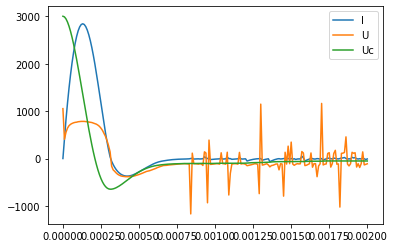

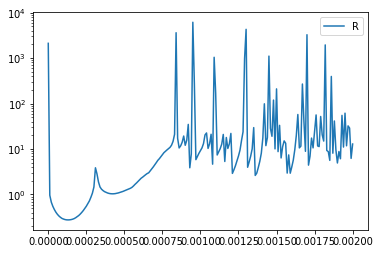

In [20]:
plot.plot(Runge_Kutta.t, Runge_Kutta.I, label='I')
plot.plot(Runge_Kutta.t, Runge_Kutta.U, label='U')
plot.plot(Runge_Kutta.t, Runge_Kutta.Uc, label='Uc')
plot.legend()
plot.savefig('Runge_Kutta.png', format='png')
plot.show()
plot.plot(Runge_Kutta.t, Runge_Kutta.R, label='R')
plot.yscale("log")
plot.legend()
plot.savefig('R_Runge_Kutta.png', format='png')
plot.show()

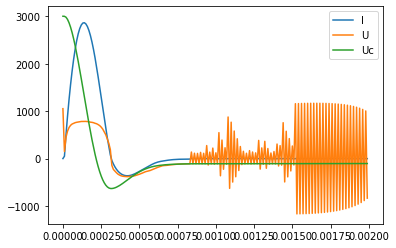

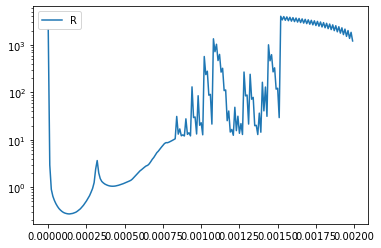

In [21]:
plot.plot(trapezoid_method_result.t, trapezoid_method_result.I, label='I')
plot.plot(trapezoid_method_result.t, trapezoid_method_result.U, label='U')
plot.plot(trapezoid_method_result.t, trapezoid_method_result.Uc, label='Uc')
plot.legend()
plot.savefig('trapezoid_method.png', format='png')
plot.show()
plot.plot(trapezoid_method_result.t, trapezoid_method_result.R, label='R')
plot.yscale("log")
plot.legend()
plot.savefig('R_trapezoid_method.png', format='png')
plot.show()